<a href="https://colab.research.google.com/github/BriacLEGUILLOU/Impact_score/blob/master/Impact_score_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

# 1. Importation librairies, données, création fonction


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn import mixture

pd.set_option('display.max_rows', 20)

In [12]:
col_CR_complet = pd.read_csv('https://raw.githubusercontent.com/BriacLEGUILLOU/Impact_score/master/col_CR_complet.csv')
ape = pd.read_csv('https://raw.githubusercontent.com/BriacLEGUILLOU/Impact_score/master/ape.csv')

def obtention_exp10(nb):
  """ Permet de convertir un nombre de la façon suivante :
  1e6 -> 6
  - 1e6 -> -6 """
  signe = np.sign(nb)
  nb = np.absolute(nb)
  if nb == 0:
    return 0
  else :
    return math.exp(nb * math.log(10)) * signe

def obtention_log10(val):
  """ Permet de convertir un nombre de la façon suivante :
  6 -> 1e6
  -6 -> -1e6 """
  if isinstance(val, float):
    signe = np.sign(val)
    nb = np.absolute(val)
    if nb == 0:
      return 0
    else :
      return math.log10(nb) * signe
  else:
    return val
def color(val):
    """
    Permet de surligner les grandes valeurs.
    """
    color = 'black'
    if isinstance(val, float):
      color = 'red' if abs(val) > 100 else 'black'
    
    return 'color: %s' % color

def filtre(df, col, filtre):
  """ Renvoie les entreprises contenant le filtre dans une colonne """
  return df[col].str.contains(filtre, case=False, na=False)

def division_colonnes(num, den):
  """ Cette fonction permet de diviser 2 colonnes """

  if (num == 0): # numérateur nul
    return 0
  elif den != 0:  # attention aux divisions par zéro
    return num / den
  else :
    return np.nan

def pos_neg(valeur):
  """ Renvoie la positif ou négatif pour la colonne sélectionnée """
  if (isinstance(valeur, float)) or (isinstance(valeur, int)):
    if valeur > 0:
      return '>0'
    elif valeur < 0:
      return '<0'
    else:
      return '=0'
  return ''

In [13]:
# Chargement des données
# Chargement rapide : for j in ['0' + str(i) for i in range(0,10)]+ [str(i) for i in list(range(10,12))]:
# Chargement complet : for j in ['0' + str(i) for i in range(0,10)]+ [str(i) for i in list(range(10,97))]:
df_log10 = pd.DataFrame()
for j in ['0' + str(i) for i in range(0,10)]+ [str(i) for i in list(range(10,17))]:
  data_log10 = pd.read_excel('/content/gdrive/My Drive/Impact Score/Export données par catégorie/data{}.xlsx'.format(j), index_col=0)
  df_log10 = pd.concat([df_log10, data_log10], axis=0)
  print(j,  'df_log10:', df_log10.shape, 'data_log10: ', data_log10.shape)
data = pd.concat([df_log10.iloc[:,0],df_log10.iloc[:,1:69].applymap(obtention_exp10), df_log10.iloc[:,69:-1]], axis=1) # donnée réelle
print('data.shape: ',data.shape)

00 df_log10: (2253, 83) data_log10:  (2253, 83)
01 df_log10: (11059, 83) data_log10:  (8806, 83)
02 df_log10: (12436, 83) data_log10:  (1377, 83)
03 df_log10: (13115, 83) data_log10:  (679, 83)
04 df_log10: (13115, 83) data_log10:  (0, 83)
05 df_log10: (13118, 83) data_log10:  (3, 83)
06 df_log10: (13365, 83) data_log10:  (247, 83)
07 df_log10: (13435, 83) data_log10:  (70, 83)
08 df_log10: (15327, 83) data_log10:  (1892, 83)
09 df_log10: (15476, 83) data_log10:  (149, 83)
10 df_log10: (32862, 83) data_log10:  (17386, 83)
11 df_log10: (35510, 83) data_log10:  (2648, 83)
12 df_log10: (35520, 83) data_log10:  (10, 83)
13 df_log10: (37683, 83) data_log10:  (2163, 83)
14 df_log10: (39601, 83) data_log10:  (1918, 83)
15 df_log10: (40391, 83) data_log10:  (790, 83)
16 df_log10: (44416, 83) data_log10:  (4025, 83)
data.shape:  (44416, 82)


# 2. Relation parent-enfant

## 2.1 Création des données par pourcentage selon les parents

In [14]:
# Création d'un df contenant les pourcentages par rapport aux parents
# Niveau enfant
colonnes_enfants = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['FJ', 'FM', 'FN', 'FO', 'FP', 'FQ',                     # Produit d'exploitation
                          'FS', 'FT', 'FU', 'FV', 'FW', 'FX', 'FY', 'FZ', 'GE',   # Charges d'exploitation
                          'GJ', 'GK', 'GL', 'GM', 'GN', 'GO',                     # Produits financiers
                          'GQ', 'GR', 'GS', 'GT',                                 # Charges financières
                          'HA', 'HB', 'HC',                                       # Produits exceptionnels
                          'HE', 'HF', 'HG'])                                # Charges exceptionnels
                   ,'Compte annuel complet']                            

# Niveau parent
colonne_parent = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['FR', 'GF',         # Résultat d'exploitation
                          'GP', 'GU',         # Résultat financier
                          'HD', 'HH']),       # Résultat exceptionnel
                          'Compte annuel complet']    

# Niveau grand parent
colonne_grand_parent = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GG', 'GV','HI']),'Compte annuel complet']

# Niveau arrière grand parent
colonne_arrière_grand_parent = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['HN', 'GG', 'GV', 'GH', 'GI', 'HI', 'HJ', 'HK']),'Compte annuel complet']

In [15]:
# Création d'un DataFrame par pourcentage : somme(enfants) / parent
data_percent = pd.DataFrame()
# Produit d'exploitation
colonnes_produits_exploitation = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['FR', 'FJ', 'FM', 'FN', 'FO', 'FP', 'FQ']),:]
for col in list(colonnes_produits_exploitation['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Total des produits d’exploitation']), axis=1)

# Charges d'exploitation
colonnes_charges_exploitation = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GF', 'FS', 'FT', 'FU', 'FV', 'FW', 'FX', 'FY', 'FZ', 'GE']),:]
for col in list(colonnes_charges_exploitation['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Total des charges d’exploitation']), axis=1)

# Produits financiers
colonnes_produits_financiers = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GP', 'GJ', 'GK', 'GL', 'GM', 'GN', 'GO']),:]
for col in list(colonnes_produits_financiers['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Total des produits financiers']), axis=1)

# Charges financières
colonnes_charges_financières = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GU', 'GQ', 'GR', 'GS', 'GT']),:]
for col in list(colonnes_charges_financières['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Total des charges financières']), axis=1)

# Produits exceptionnels
colonnes_produits_exceptionnels = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['HD', 'HA', 'HB', 'HC']),:]
for col in list(colonnes_produits_exceptionnels['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Total des produits exceptionnels']), axis=1)

# Charges exceptionnels
colonnes_charges_exceptionnelles = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['HH', 'HE', 'HF', 'HG']),:]
for col in list(colonnes_charges_exceptionnelles['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Total des charges exceptionnelles']), axis=1)


data_percent.describe()

,Chiffres d’affaires nets,Production stockée,Production immobilisée,Subventions d’exploitation,"Reprises sur amortissements et provisions, transfert de charges",Autres produits,Total des produits d’exploitation,Achats de marchandises (y compris droits de douane),Variation de stock (marchandises),Achats de matières premières et autres approvisionnements,Variation de stock (matières premières et approvisionnements),Autres achats et charges externes,"Impôts, taxes et versements assimilés",Salaires et traitements,Charges sociales,Autres charges,Total des charges d’exploitation,Produits financiers de participations,Produits des autres valeurs mobilières et créances de l’actif immobilisé,Autres intérêts et produits assimilés,Reprises sur provisions et transferts de charges financier,Différences positives de change,Produits nets sur cessions de valeurs mobilières de placement,Total des produits financiers,Dotations financières sur amortissements et provisions,Intérêts et charges assimilées,Différences négatives de change,Charges nettes sur cessions de valeurs mobilières de placement,Total des charges financières,Produits exceptionnels sur opérations de gestion,Produits exceptionnels sur opérations en capital,Reprises sur provisions et transferts de charges exceptionnel,Total des produits exceptionnels,Charges exceptionnelles sur opérations de gestion,Charges exceptionnelles sur opérations en capital,Dotations exceptionnelles aux amortissements et provisions,Total des charges exceptionnelles
count,34465.000000,17297.000000,2880.000000,13400.000000,25334.000000,29391.000000,35259.000000,14222.000000,11357.000000,28505.000000,24655.000000,36128.000000,34685.000000,31255.000000,31421.000000,29935.000000,37729.000000,4714.000000,2158.000000,12406.000000,1653.000000,2565.000000,917.000000,18879.000000,1883.000000,23336.000000,3176.000000,410.000000,33686.000000,10984.000000,12142.000000,3681.000000,18554.000000,16550.000000,10282.000000,6121.000000,28406.000000
mean,2.432892,-0.004516,0.049493,0.020912,0.028120,0.014602,0.997589,23.516353,-0.652422,2.704082,0.102110,2.269886,0.153466,2.407830,0.510677,0.009684,0.999920,12.700192,0.393742,0.968947,5.215746,0.329132,0.460712,0.972721,0.464981,0.969223,0.272739,1.791506,0.997150,0.785194,0.846325,0.555697,0.996119,0.702774,0.648922,0.602879,0.996092
std,272.808390,4.345861,0.136869,0.077836,0.659778,0.185007,0.049041,2759.064904,62.342593,238.647033,12.296711,277.850067,17.138463,297.720531,76.690520,0.107947,0.008917,891.244987,0.475771,11.900570,123.417309,11.390614,1.243039,0.162900,1.602223,3.599151,0.898656,29.361463,0.053309,23.345115,8.284462,0.365541,0.062175,7.953311,3.153371,0.387211,0.062390
min,-202.430008,-483.000000,-0.135440,-0.554993,-101.177778,-1.613086,0.000000,-4.456352,-6633.000000,-9.759019,-34.901639,-22.889558,-15.455056,-10.404565,-6.571429,-0.315574,0.000000,-11110.000000,-0.625000,-3.740807,-45.000000,-537.529412,-8.624309,0.000000,-1.596691,-38.828479,-1.152985,-2.320113,0.000000,-1.841945,-0.999625,-0.169692,0.000000,-2.570825,-1.779762,-2.229656,0.000000
25%,0.964924,-0.008339,0.001836,0.000720,0.002997,0.000011,1.000000,0.014952,-0.003303,0.109763,-0.006774,0.176762,0.006318,0.107184,0.032151,0.000026,1.000000,0.057466,0.008329,0.464053,0.044990,0.016422,0.015885,1.000000,0.040325,1.000000,0.005284,0.004582,1.000000,0.069681,0.386847,0.204971,1.000000,0.113904,0.157893,0.236053,1.000000
50%,0.988759,0.000958,0.007982,0.003063,0.008224,0.000103,1.000000,0.067969,-0.000094,0.269096,-0.000549,0.260753,0.011293,0.197418,0.056033,0.000363,1.000000,0.682996,0.149344,1.000000,0.261791,0.262160,0.217391,1.000000,0.259339,1.000000,0.067671,0.078612,1.000000,0.569735,0.927563,0.597655,1.000000,0.898060,0.744260,0.702527,1.000000
75%,0.998812,0.016133,0.031483,0.011471,0.021501,0.001089,1.000000,0.308646,0.001731,0.440926,0.003314,0.409924,0.019428,0.303833,0.087160,0.002802,1.000000,1.000000,0.936159,1.000000,0.771381,0.900787,0.914887,1.000000,0.776662,1.000000,0.388698,

In [16]:
# Création d'un DataFrame par pourcentage : Différence(parents) = Grand parent
# Résultat d'exploitation
colonnes_résultat_exploitation = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GG', 'FR', 'GF']),:]
for col in list(colonnes_résultat_exploitation['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Résultat d\'exploitation']), axis=1)

# Résultat financier
colonnes_résultat_financier = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GV', 'GP', 'GU']),:]
for col in list(colonnes_résultat_financier['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Résultat financier']), axis=1)

# Résultat exceptionnel
colonnes_résultat_exceptionnel = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['HI', 'HD', 'HH']),:]
for col in list(colonnes_résultat_exceptionnel['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Résultat exceptionnel']), axis=1)

In [ ]:
# Création d'un DataFrame par pourcentage : Somme(grand-parents) = Arrière grand parent
# Résultat en cours avant impôts
colonnes_résultat_avant_impots = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['GW', 'GG', 'GV', 'GH', 'GI']),:]
for col in list(colonnes_résultat_avant_impots['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Résultat en cours avant impôts']), axis=1)

# Bénéfices ou perte (Total des produits ‐ Total des charges)
colonnes_bénefices = col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['HN', 'GW', 'HI', 'HJ', 'HK']),:]
for col in list(colonnes_bénefices['Compte annuel complet']):
  data_percent[col] = data.apply(lambda x: division_colonnes(x[col], x['Bénéfices ou perte (Total des produits ‐ Total des charges)']), axis=1)

In [ ]:
# Conversion des données pourcentage en données logarithmiques !!!
data_percent_log10 = data_percent.applymap(obtention_log10)

In [ ]:
# Application de filtres pour éliminer les valeurs abérantes

data_percent['index'] = data_percent.index
data['index'] = data.index

# Application d'un filtre : on enlève les enfants supérieurs à 200% de leur parent, soit 800 lignes
index_anomalies_enfant = data_percent.loc[pd.DataFrame(abs(data_percent.loc[:,colonnes_enfants]) > 2).sum(axis=1) > 0,'index']
# Application d'un filtre : on enlève les parents supérieurs à 1000 fois leur grand parent, soit 400 lignes
index_anomalies_parent = []
#index_anomalies_parent = data_percent.loc[pd.DataFrame(abs(data_percent.loc[:,colonne_parent]) > 10000).sum(axis=1) > 0,'index']

#.merge(data.loc[:,['denomination','Effectif moyen du personnel','ape_name','index', 'siren']],left_on='index', right_on='index', how='left')
# .reset_index().style.applymap(afficher_gd_valeur).to_excel('/content/gdrive/My Drive/Impact Score/Data/data_percent_more_than_100.xlsx')
data_percent.drop(list(index_anomalies_enfant) + list(index_anomalies_parent), axis=0).describe()

In [ ]:
def afficher_déciles(df, col):
  """ Permet d'afficher les 10 déciles d'une colonne """
  df_col = df[col].dropna()
  liste_décile = []
  for i in range(0,100):
    liste_décile.append(np.quantile(df_col,i/100))
  return liste_décile[0:10] + liste_décile[-10:-1]

afficher_déciles(df=data, col='Résultat en cours avant impôts')

## 2.2 Réalisation d'histogrammes sur la répartition des enfants par rapport aux parents

Réalisation d'un tableau contenant les données par pourcentage par rapport à leur parent

les parents étudiés sont :
- Total des produits d’exploitation (le produit d'exploitation est globalement égal au CA)
- Total des charges d’exploitation
- Total des produits financiers
- Total des charges financières
- Total des produits exceptionnels
- Total des charges exceptionnelles

Pour les lignes o`u le parent est absent, toute la ligne est supprimée. Il convient donc de remédier aux valeurs manquantes, notamment pour les parents.

Sur toutes les données des catégories 00 à 32 (100k lignes),
il y a 107 lignes avec un pourcentage supérieur à 100 fois le parent.
Le tableau présent en annexe présente ces lignes. Les valeurs en rouge sont les valeurs supérieure à 100 fois leur parent.

action: regarder entreprise par entreprise si les données sont cohérentes

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


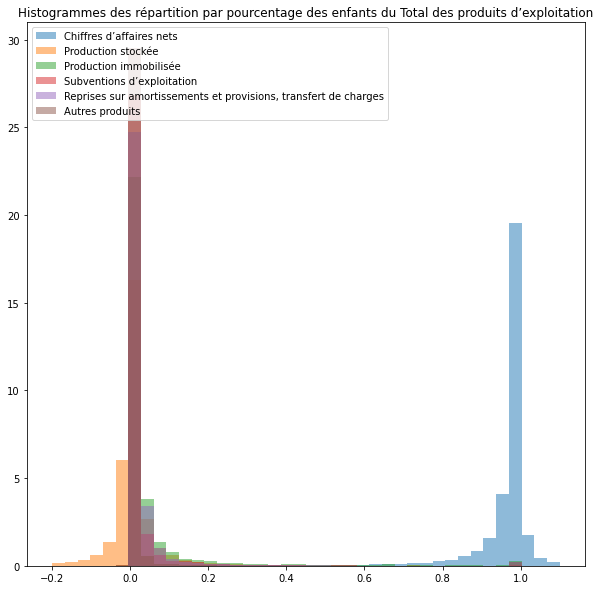

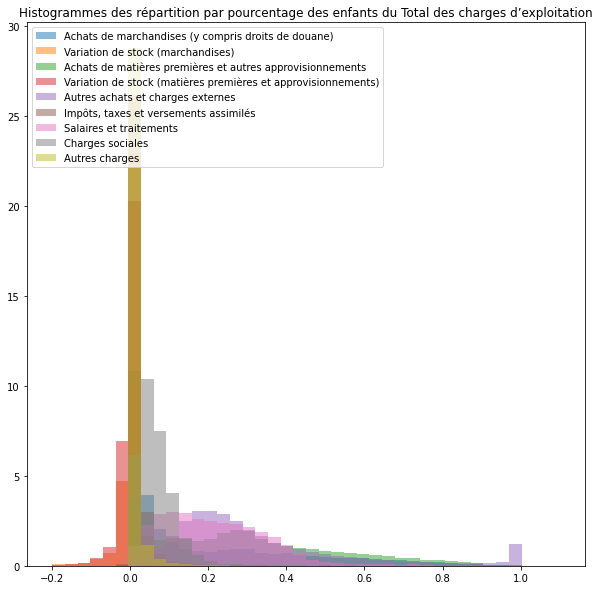

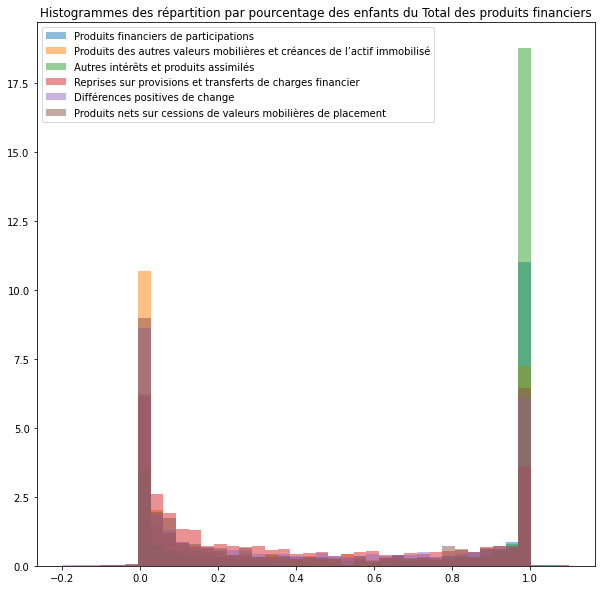

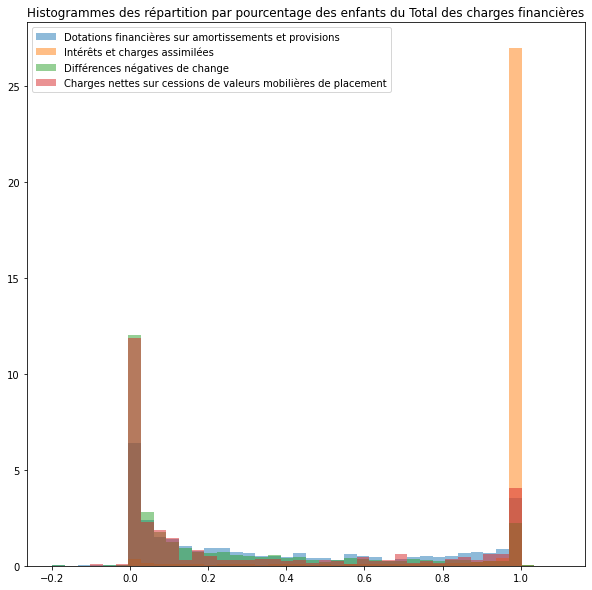

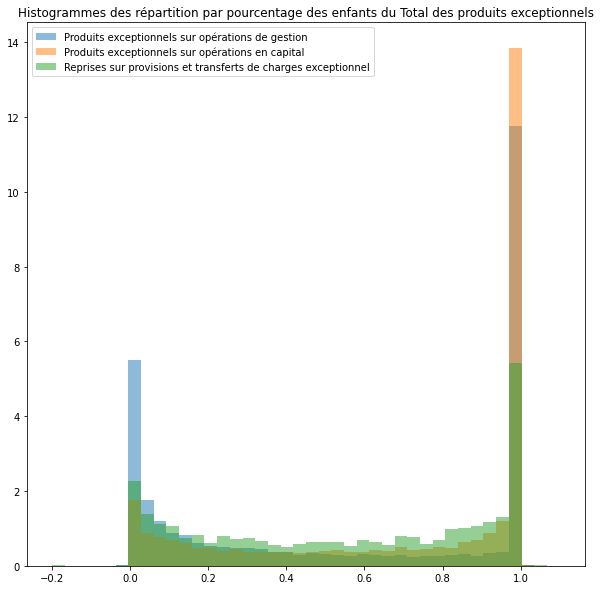

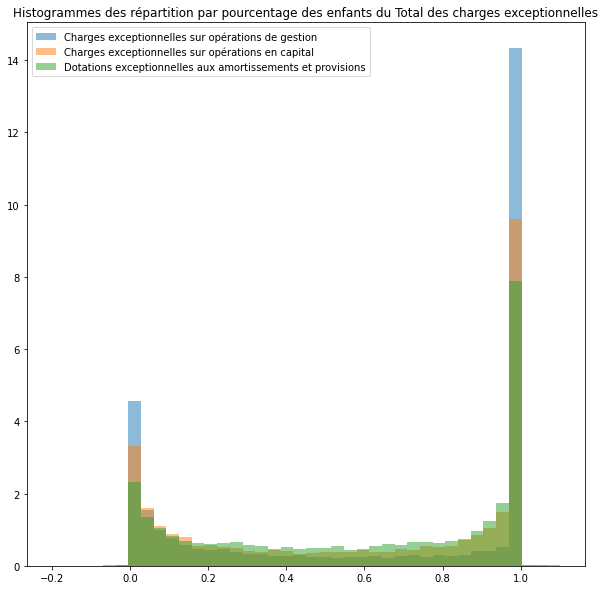

In [ ]:
#data_percent_less_than_2.hist(bins=20, figsize=(25, 15))
def hist_enfants(col_famille, range=[-0.2,1.1]):
  """ Permet la création d'un histogramme sur la répartition des enfants par rapport aux parents """
  plt.figure(figsize=(10,10))
  # identification des colonnes de la famille
  df_col_hist = col_famille['Compte annuel complet']
  # identification du parent et du dstacked : bool, optionalénominateur
  col_parent = col_famille.loc[filtre(col_famille, 'Compte annuel complet', 'Total'),'Compte annuel complet'].to_numpy()[0]
  # réalisation des histogrammes
  for col in df_col_hist.loc[df_col_hist!=col_parent]:
    plt.hist(data_percent[col], range=range, alpha=0.5, label=col, bins=40, density=True,stacked=True)
  plt.legend(loc=2)
  plt.title('Histogrammes des répartition par pourcentage des enfants du {}'.format(col_parent))
  plt.show()

hist_enfants(colonnes_produits_exploitation)
hist_enfants(colonnes_charges_exploitation)
hist_enfants(colonnes_produits_financiers)
hist_enfants(colonnes_charges_financières)
hist_enfants(colonnes_produits_exceptionnels)
hist_enfants(colonnes_charges_exceptionnelles)

On peut observer que certains parents sont globalement égaux à leur enfants :

    Chiffre d'affaire net = Total Produit d'exploitation
    Autre intérêts et produits assimilés = Total des produits financiers
    intérêts et charges assimilés = Total des charges financières
    Le Total des produits exceptionnels est souvent égal à l'un de ses enfants (Produits exceptionnels sur gestion, capital ou transfert de charge)
    Le total des charges exceptionnelles est souvent égal à l'un de ses enfants (Produits exceptionnels sur gestion, capital ou transfert de charge)

On peut aussi observer que le total des charges d'exploitation est bien réparti entre les enfants.Observation générale :

    il semble que tous les enfants soient répartis entre 0 et 100% de leur parent. Ce qui est bon signe, cela montre la fiabilité la base de données
    La plupart des enfants ont des valeurs positifs.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


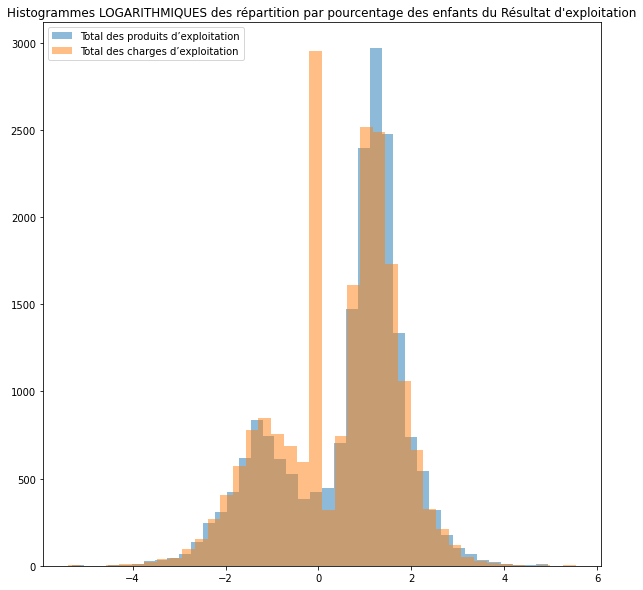

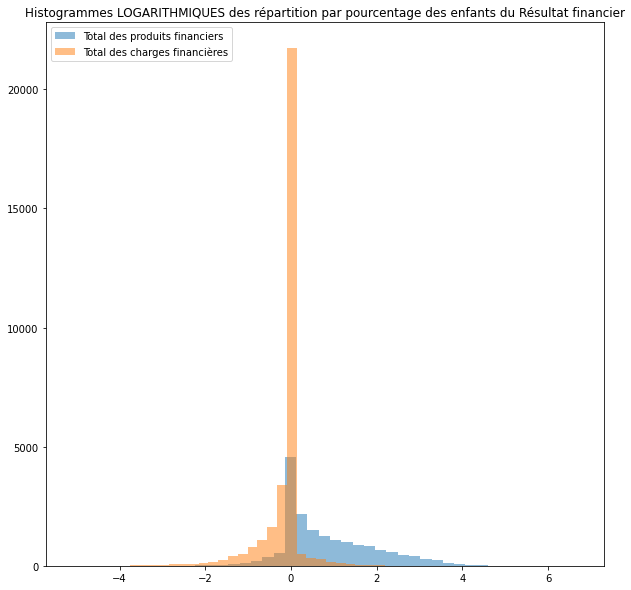

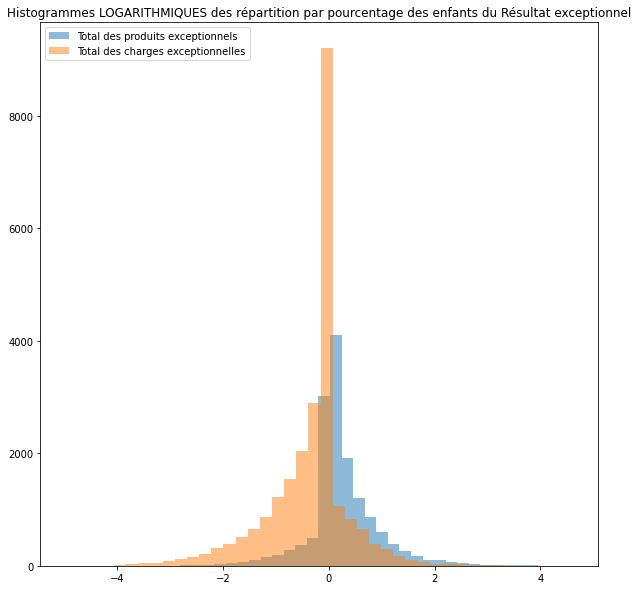

In [ ]:
#colonnes_résultat_exploitation
#colonnes_résultat_financier
#colonnes_résultat_exploitation
def hist_parent(col_famille, range=None):
  """ Permet la création d'un histogramme sur la répartition des enfants par rapport aux parents """
  plt.figure(figsize=(10,10))
  # identification des colonnes de la famille
  df_col_hist = col_famille['Compte annuel complet']
  # identification du parent et du dénominateur
  col_parent = col_famille.loc[filtre(col_famille, 'Compte annuel complet', 'Résultat'),'Compte annuel complet'].to_numpy()[0]
  # réalisation des histogrammes
  for col in df_col_hist.loc[df_col_hist!=col_parent]:
    plt.hist(data_percent_log10[col], range=range, alpha=0.5, label=col, bins=40, density=False)
  plt.legend(loc=2)
  plt.title('Histogrammes LOGARITHMIQUES des répartition par pourcentage des enfants du {}'.format(col_parent))
  plt.show()

hist_parent(colonnes_résultat_exploitation)
hist_parent(colonnes_résultat_financier)
hist_parent(colonnes_résultat_exceptionnel)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


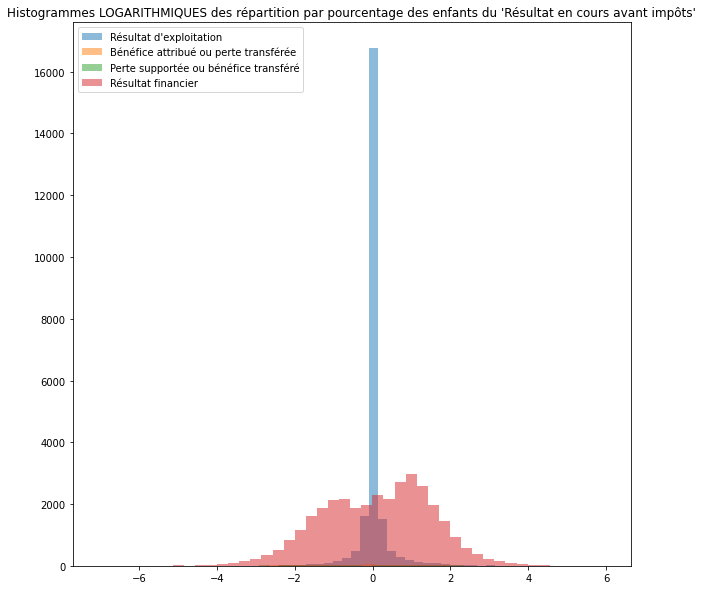

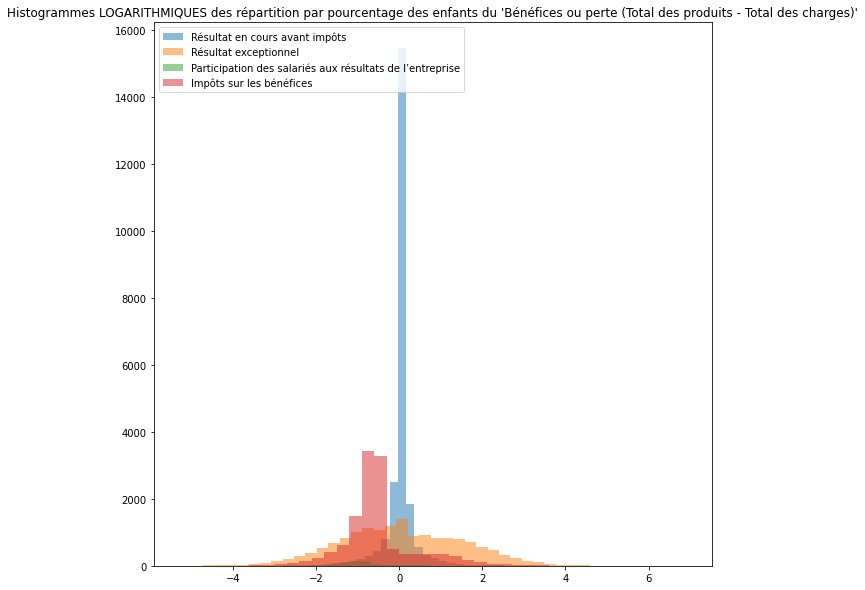

In [ ]:
#colonnes_résultat_avant_impots
#colonnes_bénefices
def hist_grand_parent(col_famille, col_grand_parent, range=None):
  """ Permet la création d'un histogramme sur la répartition des enfants par rapport aux parents """
  plt.figure(figsize=(10,10))
  # identification des colonnes de la famille
  df_col_hist = col_famille['Compte annuel complet']
  # réalisation des histogrammes
  for col in df_col_hist.loc[df_col_hist!=col_grand_parent]:
    plt.hist(data_percent_log10[col], range=range, alpha=0.5, label=col, bins=40, density=False)
  plt.legend(loc=2)
  plt.title('Histogrammes LOGARITHMIQUES des répartition par pourcentage des enfants du \'{}\''.format(col_grand_parent))
  plt.show()

hist_grand_parent(colonnes_résultat_avant_impots, col_grand_parent='Résultat en cours avant impôts')
hist_grand_parent(colonnes_bénefices, col_grand_parent='Bénéfices ou perte (Total des produits ‐ Total des charges)')

LE TAUX D'IMPOSITION EST CALCULÉ SUR
résultat en cours avant impot + résultat exceptionnel

crédit d'impôts
IS = IS + crédit d'impôts

tous les bénéfices ne sont pas imposables
les dividendes ne sont pas imposables

Produits financiers de participations(code:GJ) : ce sont les dividendes


## 2.3 étude de la position par rapport à zéro

In [ ]:
# On vérifie que le résultat d'exploitation est bien égale à la somme de ses enfants
def operation_df(df_op, op_add, op_sub, title=''):
    """ Permet de réaliser des opérations de soustraction et d'addition sur un df """
    df_tot = pd.Series(index=df_op.index, data=0)
    df_op.fillna(0,inplace=True)
    
    if len(op_add) > 0:
        for col in op_add:
            df_tot += df_op.loc[:,col]
    if len(op_sub) > 0:
        for col in op_sub:
            df_tot -= df_op.loc[:,col]
    
    df_tot.to_frame().applymap(obtention_log10).hist(bins=9)
    plt.title('Histogramme LOGARITHMIQUE de la position à zéro de \'{}\''.format(title))

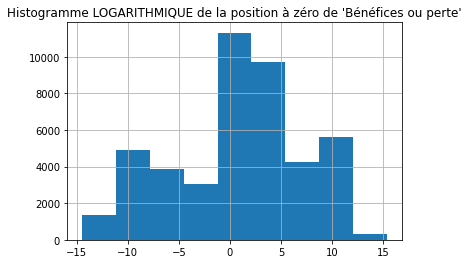

In [ ]:
# étude de la position par rapport à zéro
# Bénéfices ou perte (Total des produits ‐ Total des charges)
op_add = ['Résultat en cours avant impôts', 'Résultat exceptionnel']
op_sub = ['Bénéfices ou perte (Total des produits ‐ Total des charges)',
          'Participation des salariés aux résultats de l’entreprise',
          'Impôts sur les bénéfices']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title='Bénéfices ou perte')

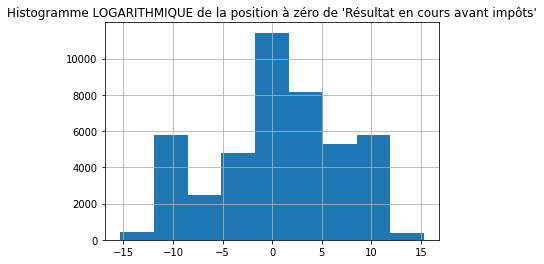

In [ ]:
# étude de la position par rapport à zéro
# Résultat en cours avant impôts
op_add = ['Résultat en cours avant impôts']
op_sub = ['Résultat d\'exploitation',
          'Résultat financier',
          'Bénéfice attribué ou perte transférée',
          'Perte supportée ou bénéfice transféré']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title='Résultat en cours avant impôts')

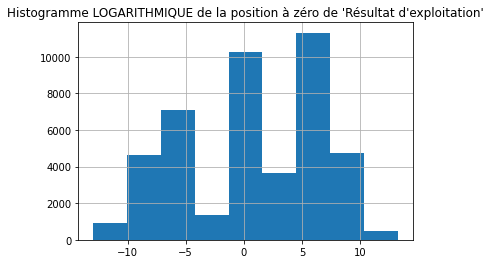

In [ ]:
# étude de la position par rapport à zéro
# Résultat d'exploitation
op_add = ['Total des produits d’exploitation']
op_sub = ['Résultat d\'exploitation',
          'Total des charges d’exploitation']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title='Résultat d\'exploitation')

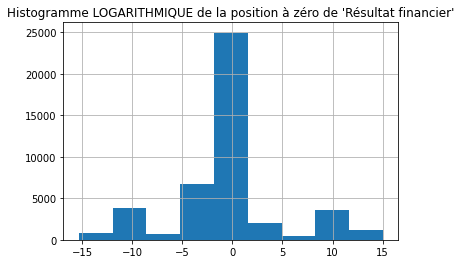

In [ ]:
# étude de la position par rapport à zéro
# Résultat financier
op_add = ['Total des produits financiers']
op_sub = ['Résultat financier',
          'Total des charges financières']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title='Résultat financier')

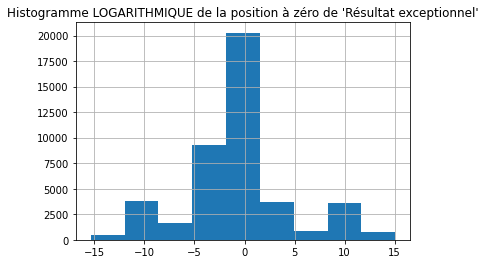

In [ ]:
# étude de la position par rapport à zéro
# Résultat exceptionnel
op_add = ['Total des produits exceptionnels']
op_sub = ['Résultat exceptionnel',
          'Total des charges exceptionnelles']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title='Résultat exceptionnel')

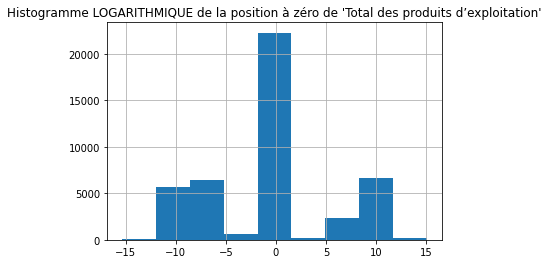

In [ ]:
# étude de la position par rapport à zéro
# Total des produits d’exploitation
op_add = ['Total des produits d’exploitation']
op_sub = colonnes_produits_exploitation.loc[colonnes_produits_exploitation.loc[:,'Compte annuel complet'] != op_add[0],'Compte annuel complet']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title=op_add[0])

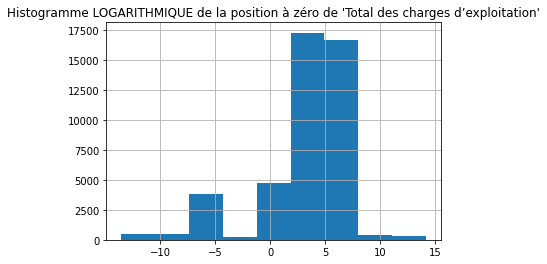

In [ ]:
# étude de la position par rapport à zéro
# Total des charges d’exploitation
op_add = ['Total des charges d’exploitation']
op_sub = colonnes_charges_exploitation.loc[colonnes_charges_exploitation.loc[:,'Compte annuel complet'] != op_add[0],'Compte annuel complet']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title=op_add[0])

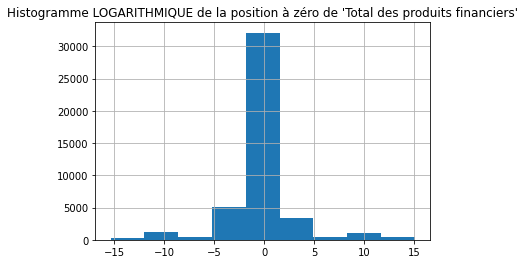

In [ ]:
# étude de la position par rapport à zéro
# Total des produits financiers
op_add = ['Total des produits financiers']
op_sub = colonnes_produits_financiers.loc[colonnes_produits_financiers.loc[:,'Compte annuel complet'] != op_add[0],'Compte annuel complet']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title=op_add[0])

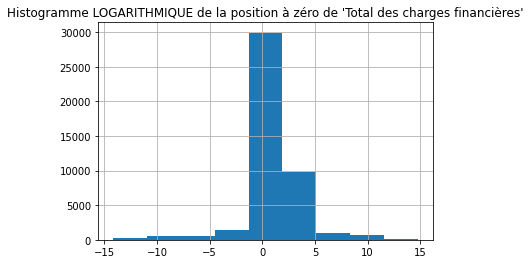

In [ ]:
# étude de la position par rapport à zéro
# Total des charges financières
op_add = ['Total des charges financières']
op_sub = colonnes_charges_financières.loc[colonnes_charges_financières.loc[:,'Compte annuel complet'] != op_add[0],'Compte annuel complet']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title=op_add[0])

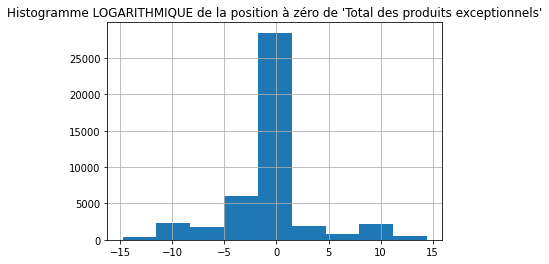

In [ ]:
# étude de la position par rapport à zéro
# Total des produits exceptionnels
op_add = ['Total des produits exceptionnels']
op_sub = colonnes_produits_exceptionnels.loc[colonnes_produits_exceptionnels.loc[:,'Compte annuel complet'] != op_add[0],'Compte annuel complet']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title=op_add[0])

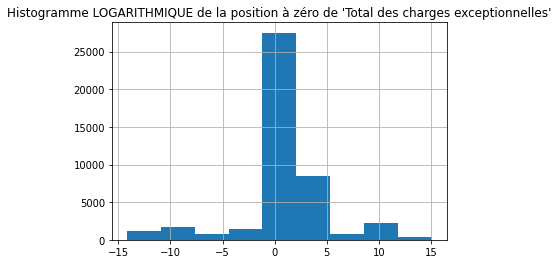

In [ ]:
# étude de la position par rapport à zéro
# Total des charges exceptionnelles
op_add = ['Total des charges exceptionnelles']
op_sub = colonnes_charges_exceptionnelles.loc[colonnes_charges_exceptionnelles.loc[:,'Compte annuel complet'] != op_add[0],'Compte annuel complet']
df_zero = operation_df(df_op=data, op_add=op_add, op_sub=op_sub, title=op_add[0])

# 3. Cluster / Corrélation

## 3.1 Identification des cluster

In [ ]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
colonnes_
clf.fit(data.loc[:,colonnes_].fillna(0))

ValueError: ignored

## 3.2 étude de la corrélation

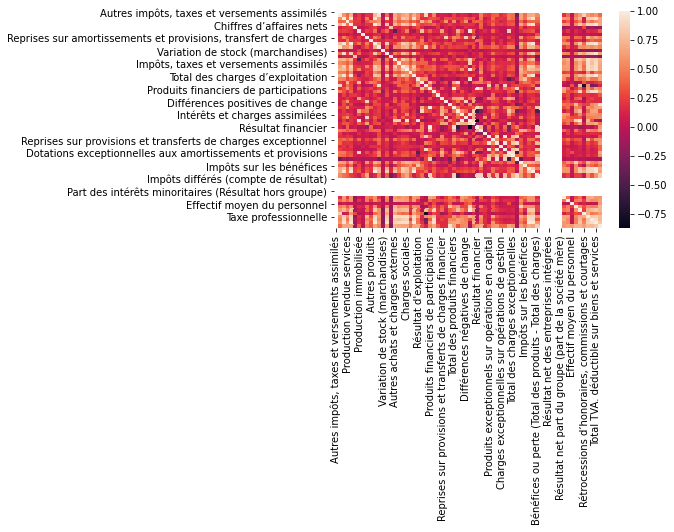

In [ ]:
sns.heatmap(data.select_dtypes(include=['float']).corr())

<Figure size 5760x144 with 0 Axes>

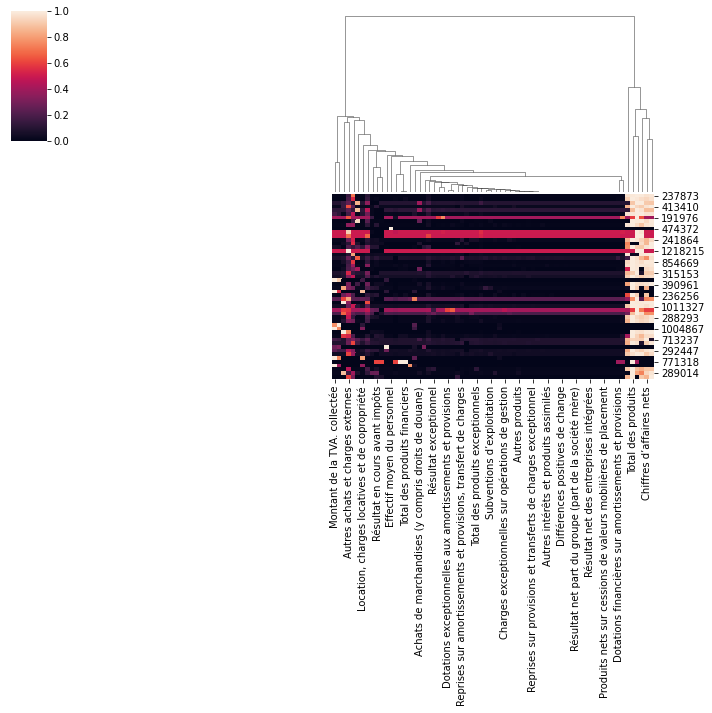

In [ ]:
plt.figure(figsize=(80,2))
sns.clustermap(data.select_dtypes(include=['float']).fillna(0).sample(50,random_state=0), col_cluster=True, row_cluster=False, standard_scale=0, dendrogram_ratio=(0.5))

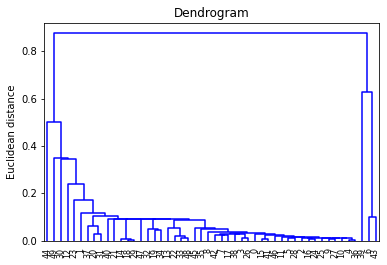

In [ ]:
#Linkage Matrix
df = data.select_dtypes(include=['float']).fillna(0).sample(50)
#plotting dendrogram
Z=linkage(df, 'single', 'correlation')
dendrogram(Z, color_threshold=0)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

# 4. calcul impact score, Disjonction des cas, comparaison entre l'IS théorique et l'IS réel

## 4.1 Calcul de l'impact score

In [ ]:
colonnes_essentielles = list(col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet']\
                   .isin(['FJ', 'FO', 'FX', 'FY', 'FZ', 'GF', 'GG', 'GV', 'HI', 'HJ', 'HK', 'HN']),'Compte annuel complet'])
colonnes_essentielles

['Chiffres d’affaires nets',
 'Subventions d’exploitation',
 'Impôts, taxes et versements assimilés',
 'Salaires et traitements',
 'Charges sociales',
 'Total des charges d’exploitation',
 "Résultat d'exploitation",
 'Résultat financier',
 'Résultat exceptionnel',
 'Participation des salariés aux résultats de l’entreprise',
 'Impôts sur les bénéfices',
 'Bénéfices ou perte (Total des produits ‐ Total des charges)']

In [ ]:
# Calcul du taux de remplissage des données
data['transparency score'] = 1 - data.loc[:,colonnes_essentielles].isna().sum(axis=1)/len(colonnes_essentielles)*0.5 - \
                            data.loc[:,col_CR_complet['Compte annuel complet']].isna().sum(axis=1)/len(col_CR_complet)*0.5
data['transparency score']

TypeError: ignored

In [ ]:
# Calcul du partage du résultat d'exploitation avec les salarié⋅es et l'état
def obtention_score_global(row):
  """ Calcul du partage du résultat d'exploitation avec les salarié⋅es et l'état """
  # L'entreprise paye des impôts et/ou de la participation ?
  if (row['Impôts sur les bénéfices'] + row['Participation des salariés aux résultats de l’entreprise']) >= 0 :
    if (row['Résultat financier'] + row['Résultat exceptionnel'] < 0):
     # Si l'entreprise ne gagne pas d'argent via ses résultats financier et exceptionnel
      if (row['Impôts sur les bénéfices'] + row['Participation des salariés aux résultats de l’entreprise']) < 10 * row['Résultat d\'exploitation']:
         # impot ou participation déclarée pas trop importante par rapport aux gains de l'entreprise, sinon ça peut être une erreur
        return (row['Impôts sur les bénéfices'] + row['Participation des salariés aux résultats de l’entreprise']) / row['Résultat d\'exploitation']
    else :
      # l'entreprise gagne de l'argent via ses résultats financier et exceptionnel
      if (row['Impôts sur les bénéfices'] + row['Participation des salariés aux résultats de l’entreprise']) < 10 * row['Impôts sur les bénéfices']:
        return (row['Impôts sur les bénéfices'] + row['Participation des salariés aux résultats de l’entreprise']) / row['Bénéfices ou perte (Total des produits ‐ Total des charges)']

data['share score'] = data.apply(obtention_score_global, axis=1)
data['share score'].describe()

count    595.000000
mean       0.432784
std        1.187987
min      -11.504253
25%        0.252734
50%        0.343763
75%        0.481668
max       23.282739
Name: share score, dtype: float64

In [ ]:
# Calcul de la proportion de charge provenant de l'économie réelle de l'entreprise
def obtention_score_cout_economique(row):
  """ Calcul de la proportion de charge provenant de l'économie réelle de l'entreprise """
  return (row['Salaires et traitements'] + row['Charges sociales'] + row['Impôts, taxes et versements assimilés'] - row['Subventions d’exploitation']) / row['Total des charges d’exploitation']

data['real economy score'] = data.apply(obtention_score_cout_economique, axis=1)
data['real economy score'].describe()

ZeroDivisionError: ignored

## 4.2 Disjonction des cas pour les entreprises

In [ ]:
def disjonction_des_cas(row):
  """ Renvoie la catégorisation de l'entreprise """
  liste_col1 = ['Impôts, taxes et versements assimilés', 'Participation des salariés aux résultats de l’entreprise']
  liste_col2 = ['Résultat financier', 'Résultat exceptionnel']
  liste_col3 = ['Résultat d\'exploitation']
  diminutif_liste = ['Impôts+Participation', 'RésFinancier+ResExceptionnel', 'ResExploitation']
  
  phrase1 = diminutif_liste[0] + pos_neg(sum([row[col1] for col1 in liste_col1]))
  phrase2 = diminutif_liste[1] + pos_neg(sum([row[col2] for col2 in liste_col2]))
  phrase3 = diminutif_liste[2] + pos_neg(sum([row[col3] for col3 in liste_col3]))
  return phrase1 + ' , ' + phrase2 + ' , ' + phrase3
  

data['Disjonction_des_cas'] = data.apply(disjonction_des_cas, axis=1)
data_no_zero = data.loc[data.loc[:,['Impôts, taxes et versements assimilés', 'Participation des salariés aux résultats de l’entreprise','Résultat financier', 'Résultat exceptionnel','Résultat d\'exploitation']].dropna().index,:]
data_no_zero['Disjonction_des_cas'].value_counts()

Impôts+Participation>0 , RésFinancier+ResExceptionnel<0 , ResExploitation>0    450
Impôts+Participation>0 , RésFinancier+ResExceptionnel>0 , ResExploitation>0    436
Impôts+Participation>0 , RésFinancier+ResExceptionnel<0 , ResExploitation<0     64
Impôts+Participation>0 , RésFinancier+ResExceptionnel>0 , ResExploitation<0     37
Impôts+Participation<0 , RésFinancier+ResExceptionnel>0 , ResExploitation>0      4
Impôts+Participation<0 , RésFinancier+ResExceptionnel>0 , ResExploitation<0      1
Impôts+Participation<0 , RésFinancier+ResExceptionnel<0 , ResExploitation>0      1
Name: Disjonction_des_cas, dtype: int64

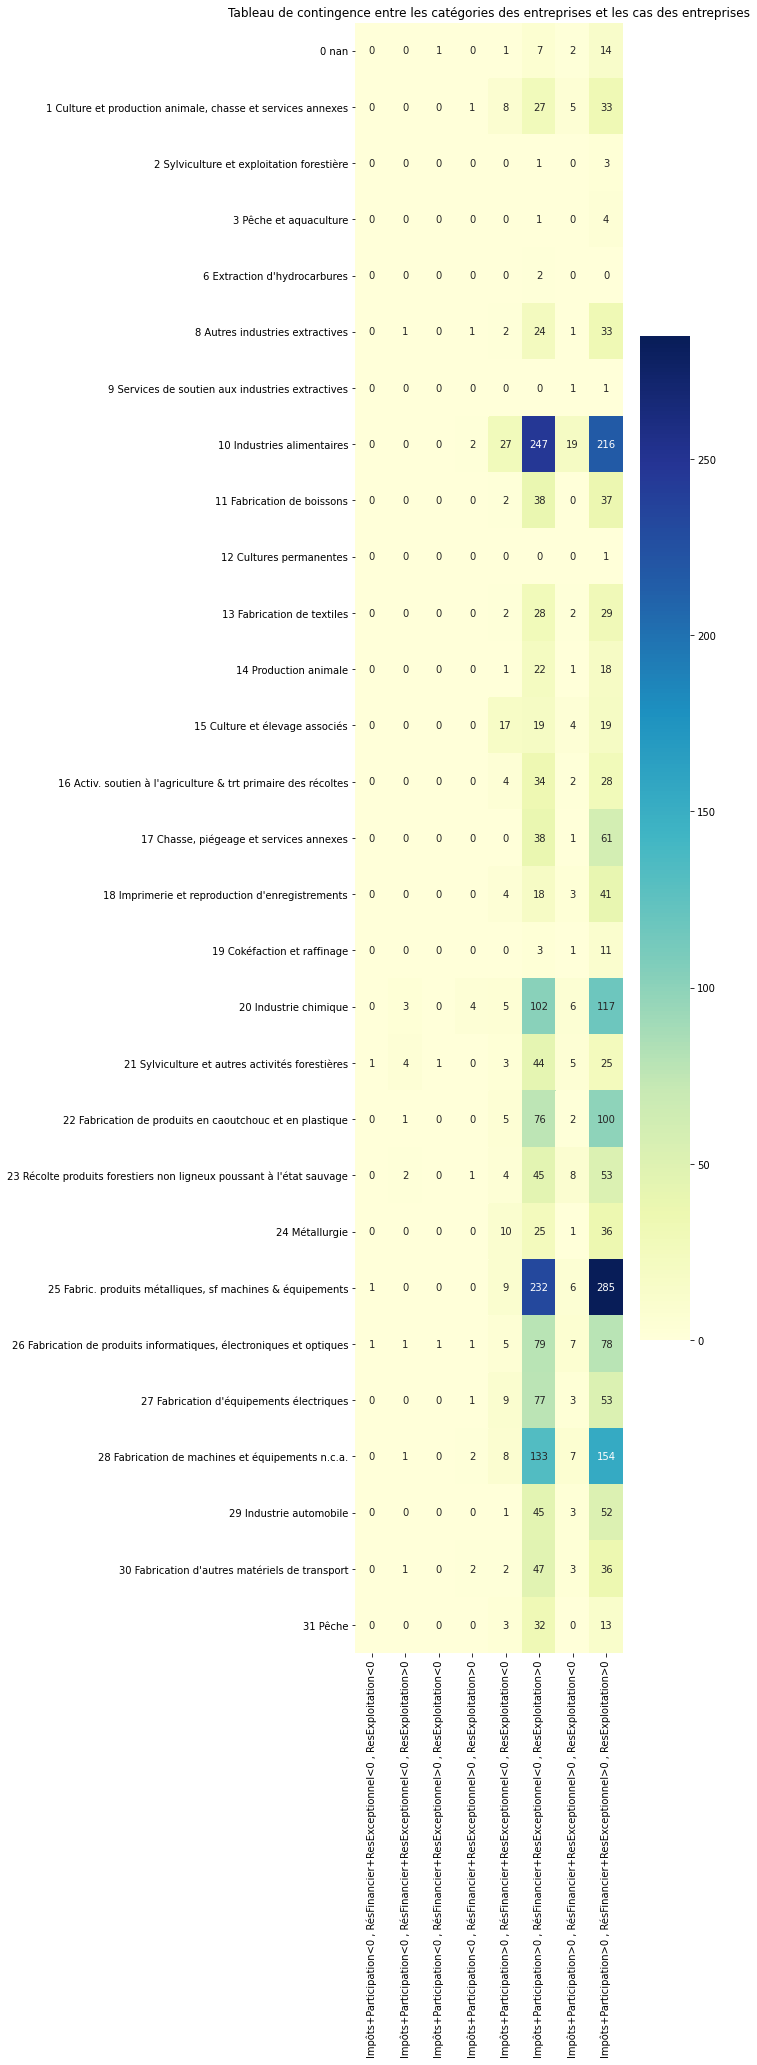

In [ ]:
# tableau de contingence entre les catégories des entreprises et les cas des entreprises
df_cat = pd.crosstab(data_no_zero['ape_cat0'],data_no_zero['Disjonction_des_cas'])
df_cat_ape = df_cat.merge(ape[ape['ape_len']<=2], left_on='ape_cat0', right_on='ape_cat0', how='left')
df_cat_ape.index = [str(x) + ' ' + str(y) for x,y in zip(df_cat_ape['ape_cat0'],df_cat_ape['ape_name'])]

# Création d'un graphique
plt.figure(figsize=(6,30))
plt.title('Tableau de contingence entre les catégories des entreprises et les cas des entreprises')
sns.heatmap(df_cat_ape.iloc[:,1:9], annot=True, fmt="d", cmap="YlGnBu")

In [ ]:
data.loc[data['Disjonction_des_cas']=='Impôts>0','taux d\'imposition'].hist(range=[-2,2])
# Observe des entreprises avec un IS <0 !
# Parmis ces entreprises, le taux d'imposition varie de -200% à 100%, ce n'est pas normal
# Le taux d'imposition devrait se situer entre 15% et 30%

In [ ]:
data.loc[data['Disjonction_des_cas']=='Impôts<0','taux d\'imposition'].hist()
# Observe des entreprises avec un IS <0 !
# Parmis ces entreprises, le taux d'imposition varie de -200% à 100%, ce n'est pas normal
# Le taux d'imposition devrait se situer entre 15% et 30%

## 4.3 Comparaison entre le taux d'imposition et l'Impôt sur les sociétés

In [ ]:
def disjonction_des_cas2(row):
  """ Renvoie la catégorisation de l'entreprise """
  liste_col1 = ['Impôts, taxes et versements assimilés']
  diminutif_liste = ['Impôts']
  
  phrase1 = diminutif_liste[0] + pos_neg(sum([row[col1] for col1 in liste_col1]))
  return phrase1

data['Disjonction_des_cas'] = data.apply(disjonction_des_cas2, axis=1)
data['Disjonction_des_cas'].value_counts()

Impôts>0    38186
Impôts=0     6042
Impôts<0      188
Name: Disjonction_des_cas, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ec1e7a58>]],
      dtype=object)

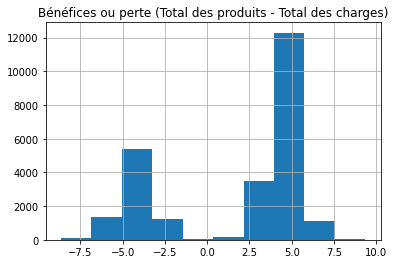

In [ ]:
pd.DataFrame(data['Bénéfices ou perte (Total des produits ‐ Total des charges)']).applymap(obtention_log10).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66ba9c5b00>,
      dtype=object)

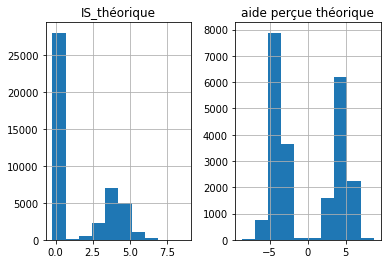

In [ ]:
def impots_societes_theorique(row):
  """ Permet de calculer l'IS théoriquement payé par les entreprises """

  if (row['Chiffres d’affaires nets'] > 0) and (row['Bénéfices ou perte (Total des produits ‐ Total des charges)'] >0):
    return 0.3 * row['Bénéfices ou perte (Total des produits ‐ Total des charges)']
  else:
    return 0


def aide_percue_theorique(row):
  """ Calcul l'aide perçue théorique de l'entreprise """
  return row['Impôts sur les bénéfices'] - row['IS_théorique']


data['IS_théorique'] = data.apply(impots_societes_theorique, axis=1)
data['aide perçue théorique'] = data.apply(aide_percue_theorique, axis=1)
data.loc[:,['IS_théorique','aide perçue théorique']].applymap(obtention_log10).hist()

il faut rajouter une étape pour vérifier le signe des colonnes

nuage de point entre résultat d'exploitation et impots
je peux calculer les aides reçus


je peux aussi faire des catégories sur l'effectif moyen
autre idée : charger les données et filtrer

- résExploitation, ResFinancier, ResExceptionnel - participation - impot = bénéfice
faire des moyennes sur plusieurs années

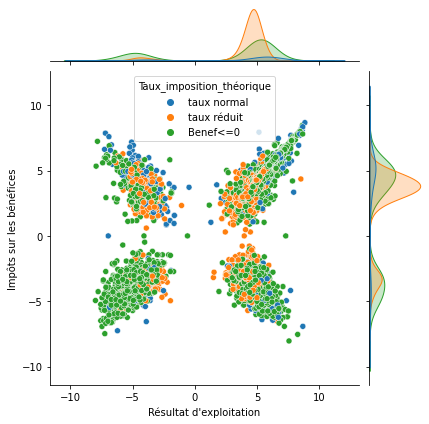

In [ ]:
data_no_na = data.loc[:,["Résultat d\'exploitation",'Impôts sur les bénéfices','Taux_imposition_théorique']].dropna().applymap(obtention_log10)
sns.jointplot(data=data, x="Résultat d\'exploitation", y='Impôts sur les bénéfices', hue='Taux_imposition_théorique')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ec128cf8>]],
      dtype=object)

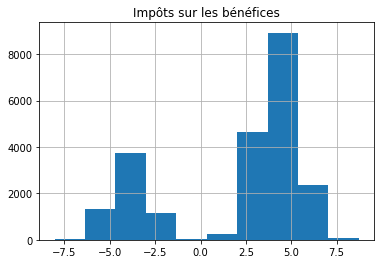

In [ ]:
pd.DataFrame(data['Impôts sur les bénéfices']).applymap(obtention_log10).hist()

In [ ]:
data_sign = data.applymap(pos_neg)
data_sign.apply(pd.Series.value_counts)

,year,"Autres impôts, taxes et versements assimilés",Ventes de marchandises,Production vendue biens,Production vendue services,Chiffres d’affaires nets,Production stockée,Production immobilisée,Subventions d’exploitation,"Reprises sur amortissements et provisions, transfert de charges",Autres produits,Total des produits d’exploitation,Achats de marchandises (y compris droits de douane),Variation de stock (marchandises),Achats de matières premières et autres approvisionnements,Variation de stock (matières premières et approvisionnements),Autres achats et charges externes,"Impôts, taxes et versements assimilés",Salaires et traitements,Charges sociales,Autres charges,Total des charges d’exploitation,Résultat d'exploitation,Bénéfice attribué ou perte transférée,Perte supportée ou bénéfice transféré,Produits financiers de participations,Produits des autres valeurs mobilières et créances de l’actif immobilisé,Autres intérêts et produits assimilés,Reprises sur provisions et transferts de charges financier,Différences positives de change,Produits nets sur cessions de valeurs mobilières de placement,Total des produits financiers,Dotations financières sur amortissements et provisions,Intérêts et charges assimilées,Différences négatives de change,Charges nettes sur cessions de valeurs mobilières de placement,Total des charges financières,Résultat financier,Résultat en cours avant impôts,Produits exceptionnels sur opérations de gestion,...,Total des produits exceptionnels,Charges exceptionnelles sur opérations de gestion,Charges exceptionnelles sur opérations en capital,Dotations exceptionnelles aux amortissements et provisions,Total des charges exceptionnelles,Résultat exceptionnel,Participation des salariés aux résultats de l’entreprise,Impôts sur les bénéfices,Total des produits,Total des charges,Bénéfices ou perte (Total des produits ‐ Total des charges),Impôts différés (compte de résultat),Résultat net des sociétés mises en équivalence,Résultat net des entreprises intégrées,Résultat Groupe (Résultat net consolidé),Part des intérêts minoritaires (Résultat hors groupe),Résultat net part du groupe (part de la société mère),Rémunération d’intermédiaires et honoraires (hors rétrocessions),"Location, charges locatives et de copropriété",Effectif moyen du personnel,Sous‐traitance,Personnel extérieur à l’entreprise,"Rétrocessions d’honoraires, commissions et courtages",Taxe professionnelle,Montant de la TVA. collectée,Total TVA. déductible sur biens et services,Dividendes,siren,denomination,enthic,postal_code,town,optimisation_fiscale,ape,ape_name,len,ape_cat0,ape_cat1,ape_cat2,ape_cat3
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44416.0,NaN,40550.0,44416.0,NaN,42163.0,44416.0,NaN,NaN,NaN,NaN,42163.0
<0,NaN,NaN,88.0,175.0,115.0,17.0,8554.0,18.0,71.0,100.0,108.0,45.0,234.0,6677.0,133.0,15486.0,73.0,188.0,42.0,227.0,234.0,71.0,8862.0,3.0,11.0,61.0,11.0,91.0,5.0,40.0,16.0,67.0,16.0,77.0,49.0,5.0,126.0,27304.0,13527.0,63.0,...,24.0,115.0,18.0,14.0,104.0,13345.0,74.0,6312.0,29.0,53.0,8078.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,6.0,NaN,16.0,9.0,7.0,56.0,6.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
=0,NaN,44416.0,24504.0,18592.0,17092.0,5871.0,25276.0,41208.0,29358.0,16026.0,13541.0,9242.0,28702.0,31906.0,12472.0,16590.0,4611.0,6042.0,9664.0,9484.0,12908.0,6690.0,20500.0,43991.0,43967.0,38000.0,41407.0,27420.0,42308.0,40948.0,43208.0,26052.0,42355.0,19309.0,41029.0,43993.0,10826.0,8476.0,5514.0,29208.0,...,25934.0,26256.0,33258.0,37752.0,16121.0,15404.0,41650.0,21862.0,5814.0,6664.0,19257.0,44416.0,44416.0,44416.0,44416.0,44416.0,44416.0,35801.0,36330.0,33981.0,38515.0,40812.0,43575.0,37512.0,36175.0,36239.0,42822.0,NaN,NaN,319.0,NaN,NaN,44397.0,2253.0,NaN,NaN,2253.0,4911.0,7384.0,2253.0
>0,44416.0,NaN,19824.

In [ ]:
def taux_imposition_theorique(row):
  """ calcul du taux d'imposition théorique 
  problème l'IS est égale à l'IS + crédit d'impôts """
  # https://www.service-public.fr/professionnels-entreprises/vosdroits/F23575
  
  if row['Bénéfices ou perte (Total des produits ‐ Total des charges)']  > 0:
    # L'entreprise réalise des bénéfices, elle peut payer des impôts
    if row['Chiffres d’affaires nets'] <= 0:
      return 'Benef>0,CA<=0'
    elif row['Chiffres d’affaires nets'] < 7.63 * 1e6:
      return 'taux réduit'
    else :
      return 'taux normal'
  else:
    return 'Benef<=0'

data['Taux_imposition_théorique'] = data.apply(taux_imposition_theorique,axis=1)
data['Taux_imposition_théorique'].value_counts()

Benef<=0         27335
taux réduit      14686
taux normal       2393
Benef>0,CA<=0        2
Name: Taux_imposition_théorique, dtype: int64